# Import and prepare data 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Load Kalazar data
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')

# Ensure 'date' column is in datetime format
kal_data['date'] = pd.to_datetime(kal_data['date'])

# Group Kalazar data by date and count cases
kal_data = kal_data.groupby('date').size().reset_index(name='case_count')

# Filter for dates greater than or equal to 2015-11-01
kal_data = kal_data[kal_data["date"] >= "2015-11-01"]

# Fill missing values in case count with 0
kal_data['case_count'].fillna(0, inplace=True)

# Define Features (X) and Target (y)
X = kal_data[['date']].copy()  # Using date as a feature (Need to extract time-based features)
y = kal_data['case_count']  # Target variable

# Convert 'date' to numerical features (Year, Month, Day, Day of Week)
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['day_of_week'] = X['date'].dt.dayofweek

# Drop the original 'date' column (since models can't process dates directly)
X.drop(columns=['date'], inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check dataset structure
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (1065, 4), Test set size: (267, 4)


<positron-console-cell-6>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




## ARIMA 

<positron-console-cell-7>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/berhe/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


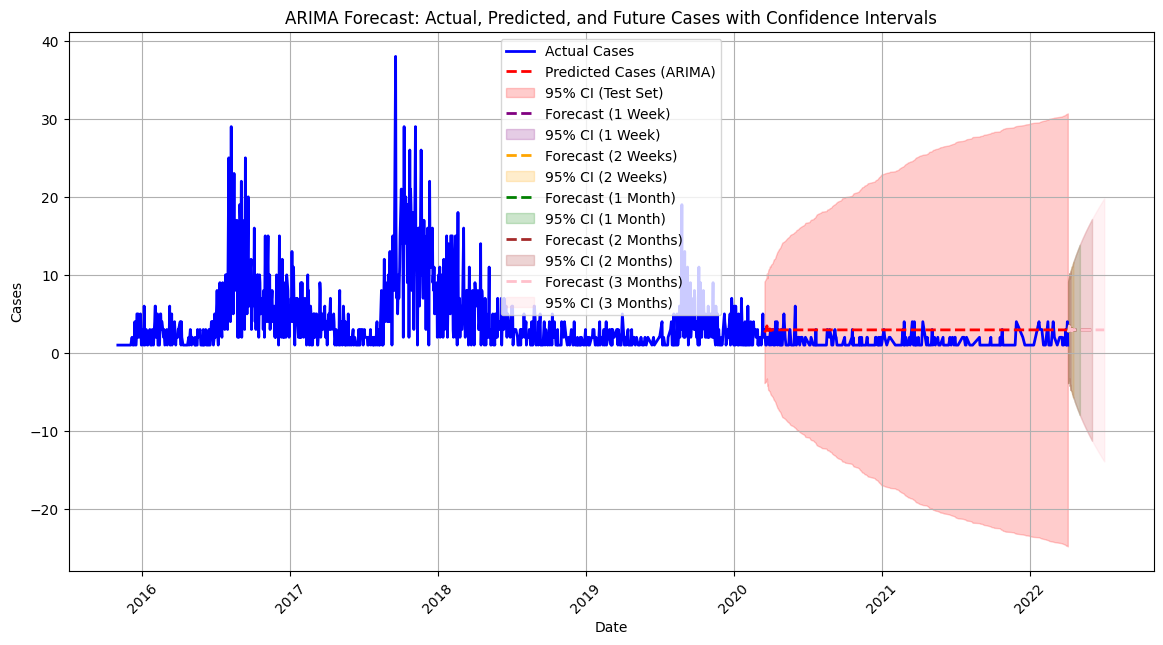

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load Data
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')

# Ensure datetime format and aggregate by date
kal_data['date'] = pd.to_datetime(kal_data['date'])
kal_data = kal_data.groupby('date').size().reset_index(name='case_count')

# Filter for relevant time period
kal_data = kal_data[kal_data["date"] >= "2015-11-01"]

# Handle missing values
kal_data['case_count'].fillna(0, inplace=True)

# 🔥 Split Time-Series Data Sequentially (80% Train, 20% Test)
train_size = int(len(kal_data) * 0.8)
train, test = kal_data.iloc[:train_size], kal_data.iloc[train_size:]

# 🔥 Fit ARIMA Model
arima_model = ARIMA(train['case_count'], order=(5,1,0))
arima_fitted = arima_model.fit()

# 🔥 Predict on Test Set with Confidence Intervals
forecast_obj = arima_fitted.get_forecast(steps=len(test), alpha=0.05)
forecast = forecast_obj.predicted_mean  # Forecasted values
conf_int = forecast_obj.conf_int()  # 95% Confidence Intervals

# 🔥 Generate Future Forecasts (7 days, 14 days, 30 days, 60 days, 90 days)
future_steps = [7, 14, 30, 60, 90]
future_forecasts = {}
future_dates = {}
future_conf_int = {}

for steps in future_steps:
    future_obj = arima_fitted.get_forecast(steps=steps)
    future_forecasts[steps] = future_obj.predicted_mean
    future_conf_int[steps] = future_obj.conf_int()  # Confidence Intervals
    future_dates[steps] = pd.date_range(start=kal_data['date'].iloc[-1], periods=steps+1, freq='D')[1:]  # Exclude last observed date

# 🔥 Plot Actual vs Predicted + Future Forecasts with CI
plt.figure(figsize=(14, 7))

# Plot Actual Cases
plt.plot(kal_data['date'], kal_data['case_count'], label="Actual Cases", color="blue", linewidth=2)

# Plot Predicted Cases on Test Set
plt.plot(test['date'], forecast, label="Predicted Cases (ARIMA)", color="red", linestyle="--", linewidth=2)

# Plot Confidence Intervals for Test Predictions
plt.fill_between(test['date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="red", alpha=0.2, label="95% CI (Test Set)")

# Plot Future Predictions with Confidence Intervals
colors = ["purple", "orange", "green", "brown", "pink"]
labels = ["1 Week", "2 Weeks", "1 Month", "2 Months", "3 Months"]

for i, steps in enumerate(future_steps):
    plt.plot(future_dates[steps], future_forecasts[steps], linestyle="--", linewidth=2, color=colors[i], label=f"Forecast ({labels[i]})")
    
    # Confidence Interval
    plt.fill_between(future_dates[steps], future_conf_int[steps].iloc[:, 0], future_conf_int[steps].iloc[:, 1], 
                     color=colors[i], alpha=0.2, label=f"95% CI ({labels[i]})")

plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("ARIMA Forecast: Actual, Predicted, and Future Cases with Confidence Intervals")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



# Random forest 

Random Forest MSE: 7.97
Random Forest RMSE: 2.82
Random Forest R² Score: 0.55


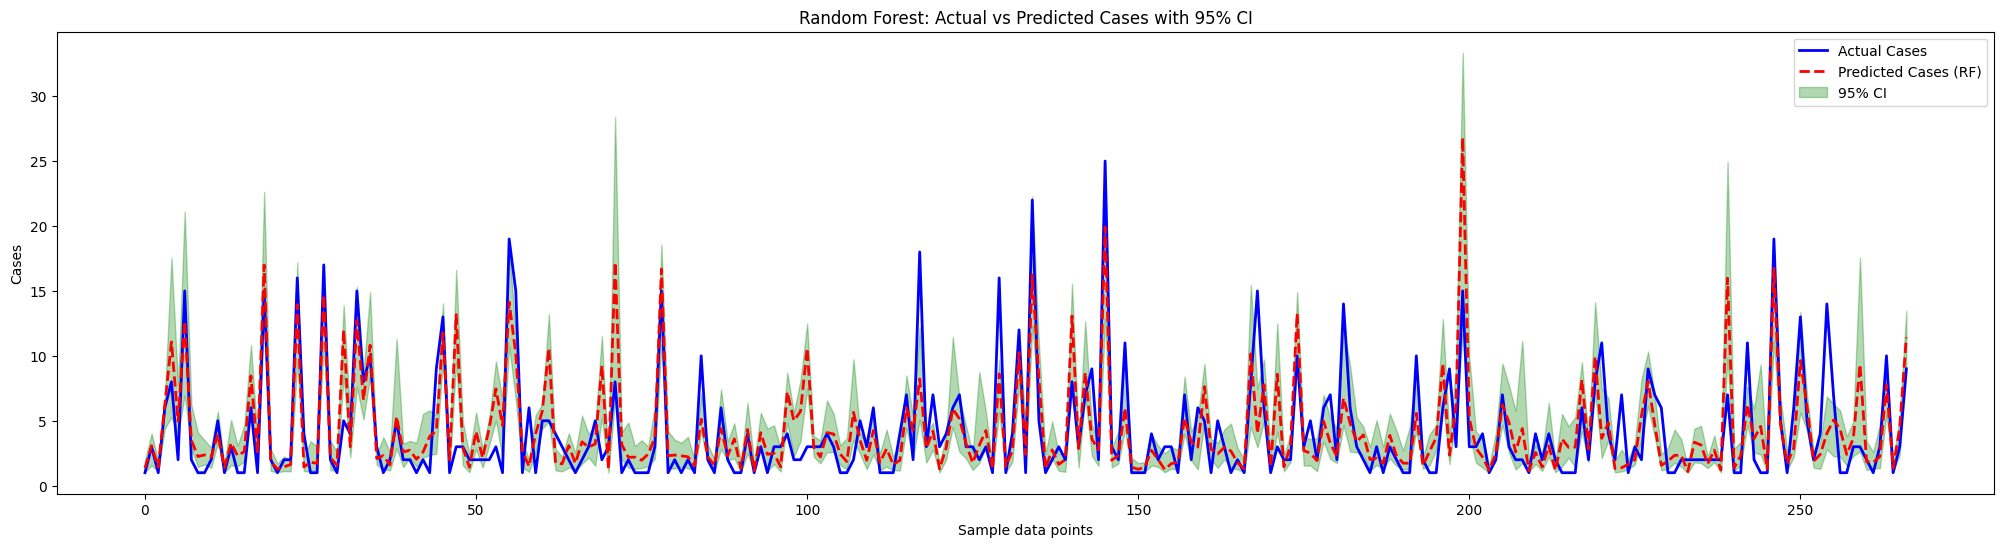

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ensure X_train and y_train are in Pandas format
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Calculate Performance Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R² Score: {r2_rf:.2f}")

# Compute Prediction Intervals (95% CI) using Bootstrapping
n_bootstraps = 1000
y_pred_bootstrap = np.zeros((n_bootstraps, len(y_test)))  # Store bootstrap predictions

for i in range(n_bootstraps):
    # Bootstrap resampling
    X_train_sample = X_train_df.sample(frac=1, replace=True, random_state=i)
    y_train_sample = y_train_df.sample(frac=1, replace=True, random_state=i)
    
    # Train new RF model per bootstrap sample
    rf_model_bootstrap = RandomForestRegressor(n_estimators=100, random_state=i)
    rf_model_bootstrap.fit(X_train_sample, y_train_sample)
    
    # Predict
    y_pred_bootstrap[i, :] = rf_model_bootstrap.predict(X_test)

# Compute 95% Confidence Intervals
lower_bound = np.percentile(y_pred_bootstrap, 2.5, axis=0)
upper_bound = np.percentile(y_pred_bootstrap, 97.5, axis=0)

# Plot Actual vs Predicted with CI
plt.figure(figsize=(25, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Cases", color="blue", linewidth=2)
plt.plot(y_pred_rf, label="Predicted Cases (RF)", color="red", linestyle="--", linewidth=2)
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='green', alpha=0.3, label="95% CI")
plt.xlabel("Sample data points")
plt.ylabel("Cases")
plt.title("Random Forest: Actual vs Predicted Cases with 95% CI")
plt.legend()
plt.show()


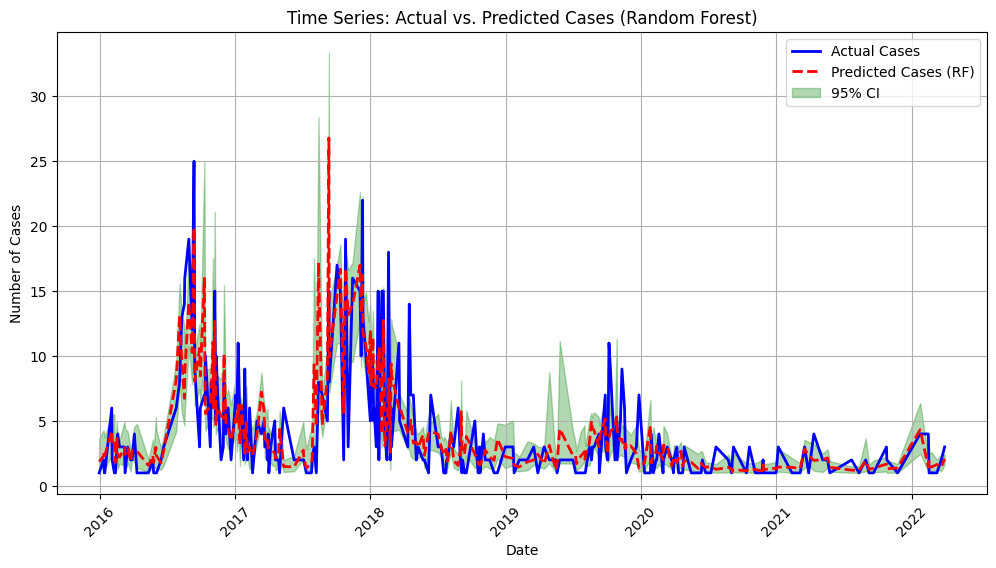

In [9]:
# Ensure y_test has a datetime index from merged_df
time_index = kal_data.loc[y_test.index, 'date']  # Adjust 'date' column name if different

# Convert to DataFrame for plotting
df_results = pd.DataFrame({
    "Date": time_index,
    "Actual Cases": y_test.values,
    "Predicted Cases (RF)": y_pred_rf,
    "Lower 95% CI": lower_bound,
    "Upper 95% CI": upper_bound
})

# Sort by Date
df_results = df_results.sort_values(by="Date")

# Plot Actual vs. Predicted Cases
plt.figure(figsize=(12, 6))
plt.plot(df_results["Date"], df_results["Actual Cases"], label="Actual Cases", color="blue", linewidth=2)
plt.plot(df_results["Date"], df_results["Predicted Cases (RF)"], label="Predicted Cases (RF)", color="red", linestyle="--", linewidth=2)

# Confidence Interval Shading
plt.fill_between(df_results["Date"], df_results["Lower 95% CI"], df_results["Upper 95% CI"], 
                 color='green', alpha=0.3, label="95% CI")
                 
# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("Time Series: Actual vs. Predicted Cases (Random Forest)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


<positron-console-cell-10>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<positron-console-cell-10>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


🌳 Random Forest Performance:
➡️  MSE: 7.96
➡️  RMSE: 2.82
➡️  R² Score: 0.56

📅 Future Predictions with CI (Random Forest):
➡️  2 Weeks: 1.46
➡️  1 Month: 1.15
➡️  2 Months: 1.43
➡️  3 Months: 1.42


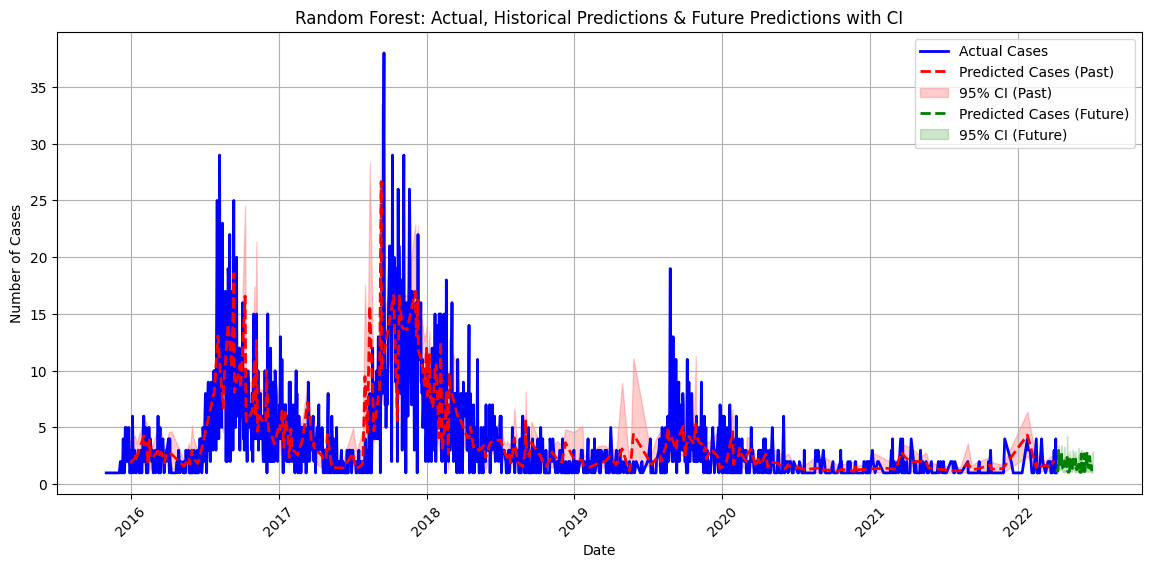

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 🔥 Load Data (Ensure `kal_data` exists)
# kal_data should be a DataFrame with 'date' and 'case_count' columns
assert 'kal_data' in locals() or 'kal_data' in globals(), "kal_data DataFrame is missing!"

# 🔥 Feature Engineering
kal_data['year'] = kal_data['date'].dt.year
kal_data['month'] = kal_data['date'].dt.month
kal_data['day'] = kal_data['date'].dt.day
kal_data['day_of_week'] = kal_data['date'].dt.dayofweek

# 🔥 Prepare Features and Target Variable
X = kal_data.drop(columns=['date', 'case_count'])  # Features
y = kal_data['case_count']  # Target variable

# 🔥 Handle Missing Values (if any)
X.fillna(method='ffill', inplace=True)
y.fillna(method='ffill', inplace=True)

# 🔥 Split Data into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔥 Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔥 Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 🔥 Predict on Test Set
y_pred_rf = rf_model.predict(X_test_scaled)

# 🔥 Compute Performance Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌳 Random Forest Performance:")
print(f"➡️  MSE: {mse_rf:.2f}")
print(f"➡️  RMSE: {rmse_rf:.2f}")
print(f"➡️  R² Score: {r2_rf:.2f}")

# 🔥 Bootstrapping for 95% CI on Historical Predictions (Test Data)
n_bootstraps = 1000
y_pred_historical_rf_bootstrap = np.zeros((n_bootstraps, len(y_test)))

for i in range(n_bootstraps):
    sample_X, sample_y = X_train.sample(frac=1, replace=True, random_state=i), y_train.sample(frac=1, replace=True, random_state=i)
    rf_model.fit(scaler.transform(sample_X), sample_y)
    y_pred_historical_rf_bootstrap[i] = rf_model.predict(X_test_scaled)

# 🔥 Compute 95% Confidence Intervals for Historical Predictions
lower_bound_historical_rf = np.percentile(y_pred_historical_rf_bootstrap, 2.5, axis=0)
upper_bound_historical_rf = np.percentile(y_pred_historical_rf_bootstrap, 97.5, axis=0)

# 🔥 Historical Predictions DataFrame
df_results_rf = pd.DataFrame({
    "Date": kal_data.loc[y_test.index, 'date'],
    "Actual Cases": y_test.values,
    "Predicted Cases (RF)": y_pred_rf,
    "Lower Bound (95% CI)": lower_bound_historical_rf,
    "Upper Bound (95% CI)": upper_bound_historical_rf
}).sort_values(by="Date")

# 🔥 Generate Future Dates (90 Days Ahead)
last_date = kal_data['date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90, freq='D')

# 🔥 Convert to DataFrame
future_df = pd.DataFrame({"date": future_dates})

# 🔥 Extract Time-Based Features
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['day_of_week'] = future_df['date'].dt.dayofweek

# 🔥 Standardize Features Using Pre-Fitted Scaler
X_future_scaled = scaler.transform(future_df.drop(columns=['date']))

# 🔥 Predict Future Cases
y_pred_future_rf = rf_model.predict(X_future_scaled)

# 🔥 Bootstrapping for 95% CI on Future Predictions
y_pred_future_rf_bootstrap = np.zeros((n_bootstraps, len(y_pred_future_rf)))

for i in range(n_bootstraps):
    sample_X, sample_y = X_train.sample(frac=1, replace=True, random_state=i), y_train.sample(frac=1, replace=True, random_state=i)
    rf_model.fit(scaler.transform(sample_X), sample_y)
    y_pred_future_rf_bootstrap[i] = rf_model.predict(X_future_scaled)

# 🔥 Compute 95% Confidence Intervals for Future Predictions
lower_bound_future_rf = np.percentile(y_pred_future_rf_bootstrap, 2.5, axis=0)
upper_bound_future_rf = np.percentile(y_pred_future_rf_bootstrap, 97.5, axis=0)

# 🔥 Add Predictions & CI to Future DataFrame
future_df['Predicted Cases (RF)'] = y_pred_future_rf
future_df['Lower Bound (95% CI)'] = lower_bound_future_rf
future_df['Upper Bound (95% CI)'] = upper_bound_future_rf

# 🔥 Extract Specific Future Predictions
predictions = {
    "2 Weeks": future_df.loc[future_df['date'] == last_date + timedelta(weeks=2), 'Predicted Cases (RF)'],
    "1 Month": future_df.loc[future_df['date'] == last_date + timedelta(weeks=4), 'Predicted Cases (RF)'],
    "2 Months": future_df.loc[future_df['date'] == last_date + timedelta(weeks=8), 'Predicted Cases (RF)'],
    "3 Months": future_df.loc[future_df['date'] == last_date + timedelta(weeks=12), 'Predicted Cases (RF)']
}

print("\n📅 Future Predictions with CI (Random Forest):")
for period, value in predictions.items():
    print(f"➡️  {period}: {value.iloc[0] if not value.empty else 'N/A'}")

# 🔥 Plot Historical & Future Predictions with Confidence Intervals
plt.figure(figsize=(14, 6))

# 📌 Plot historical actual cases
plt.plot(kal_data['date'], kal_data['case_count'], label="Actual Cases", color="blue", linewidth=2)

# 📌 Plot historical predicted cases
plt.plot(df_results_rf["Date"], df_results_rf["Predicted Cases (RF)"], label="Predicted Cases (Past)", color="red", linestyle="--", linewidth=2)

# 📌 Add confidence intervals for historical predictions
plt.fill_between(df_results_rf['Date'], df_results_rf['Lower Bound (95% CI)'], df_results_rf['Upper Bound (95% CI)'], color='red', alpha=0.2, label="95% CI (Past)")

# 📌 Plot future predictions
plt.plot(future_df['date'], future_df['Predicted Cases (RF)'], label="Predicted Cases (Future)", color="green", linestyle="--", linewidth=2)

# 📌 Add confidence intervals for future predictions
plt.fill_between(future_df['date'], future_df['Lower Bound (95% CI)'], future_df['Upper Bound (95% CI)'], color='green', alpha=0.2, label="95% CI (Future)")

# 📌 Formatting
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("Random Forest: Actual, Historical Predictions & Future Predictions with CI")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# 🔥 Show plot
plt.show()


## Xgboost autoregression

XGBoost MSE: 7.04
XGBoost RMSE: 2.65
XGBoost R² Score: 0.61


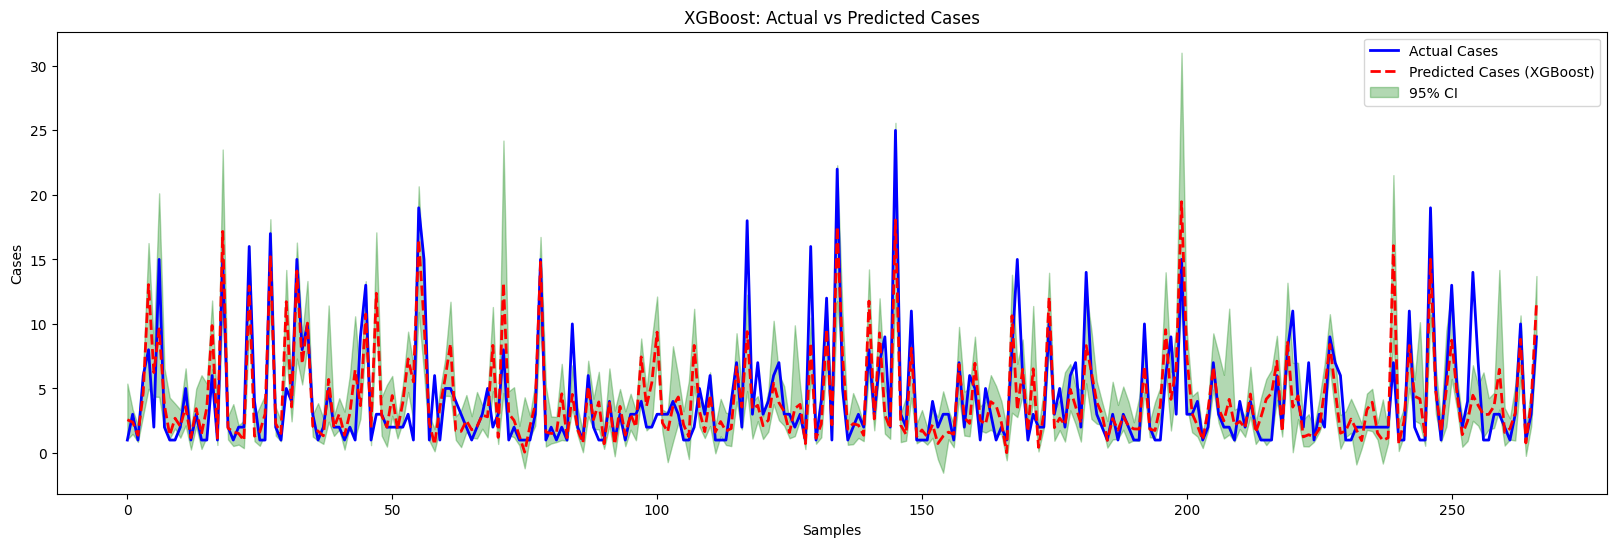

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Convert data to Pandas DataFrame (only if needed)
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Train XGBoost Model
xg_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xg_model.fit(X_train_df, y_train_df)

# Predict and evaluate
y_pred_xg = xg_model.predict(X_test_np)

# Compute Performance Metrics
mse_xg = mean_squared_error(y_test_np, y_pred_xg)
rmse_xg = np.sqrt(mse_xg)
r2_xg = r2_score(y_test_np, y_pred_xg)

print(f"XGBoost MSE: {mse_xg:.2f}")
print(f"XGBoost RMSE: {rmse_xg:.2f}")
print(f"XGBoost R² Score: {r2_xg:.2f}")

# 🔥 Compute Prediction Intervals using Bootstrapping
n_bootstraps = 1000
y_pred_bootstrap = np.array([
    xg_model.fit(
        X_train_df.sample(frac=1, replace=True, random_state=i),  # Bootstrap X (Pandas)
        y_train_df.sample(frac=1, replace=True, random_state=i)   # Bootstrap y (Pandas)
    ).predict(X_test_np) for i in range(n_bootstraps)
])

# Compute 95% Confidence Intervals
lower_bound = np.percentile(y_pred_bootstrap, 2.5, axis=0)
upper_bound = np.percentile(y_pred_bootstrap, 97.5, axis=0)

# 📊 Visualization: Actual vs Predicted with Confidence Intervals
plt.figure(figsize=(20, 6))
plt.plot(y_test_np, label="Actual Cases", color="blue", linewidth=2)
plt.plot(y_pred_xg, label="Predicted Cases (XGBoost)", color="red", linestyle="--", linewidth=2)
plt.fill_between(range(len(y_test_np)), lower_bound, upper_bound, color='green', alpha=0.3, label="95% CI")
plt.xlabel("Samples")
plt.ylabel("Cases")
plt.title("XGBoost: Actual vs Predicted Cases")
plt.legend()
plt.show()


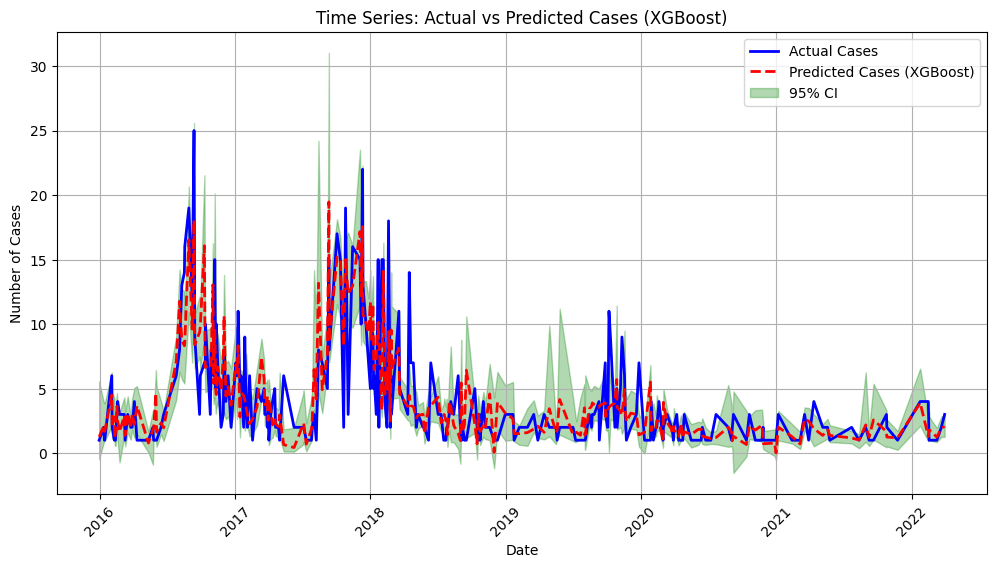

In [12]:
# Extract date index from merged_df for y_test
time_index = kal_data.loc[y_test.index, 'date']  # Ensure 'date' column exists

# Convert predictions to DataFrame for plotting
df_results = pd.DataFrame({
    "Date": time_index,
    "Actual Cases": y_test_np,
    "Predicted Cases (XGBoost)": y_pred_xg,
    "Lower 95% CI": lower_bound,
    "Upper 95% CI": upper_bound
})

# Sort by Date (just in case)
df_results = df_results.sort_values(by="Date")

# Plot Actual vs Predicted Cases with CI
plt.figure(figsize=(12, 6))
plt.plot(df_results["Date"], df_results["Actual Cases"], label="Actual Cases", color="blue", linewidth=2)
plt.plot(df_results["Date"], df_results["Predicted Cases (XGBoost)"], label="Predicted Cases (XGBoost)", color="red", linestyle="--", linewidth=2)

# Confidence Interval Shading
plt.fill_between(df_results["Date"], df_results["Lower 95% CI"], df_results["Upper 95% CI"], 
                 color='green', alpha=0.3, label="95% CI")

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("Time Series: Actual vs Predicted Cases (XGBoost)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


📅 Future Predictions with CI:
➡️  2 Weeks: 3.521458864212036
➡️  1 Month: 3.521458864212036
➡️  2 Months: 3.521458864212036
➡️  3 Months: 3.521458864212036


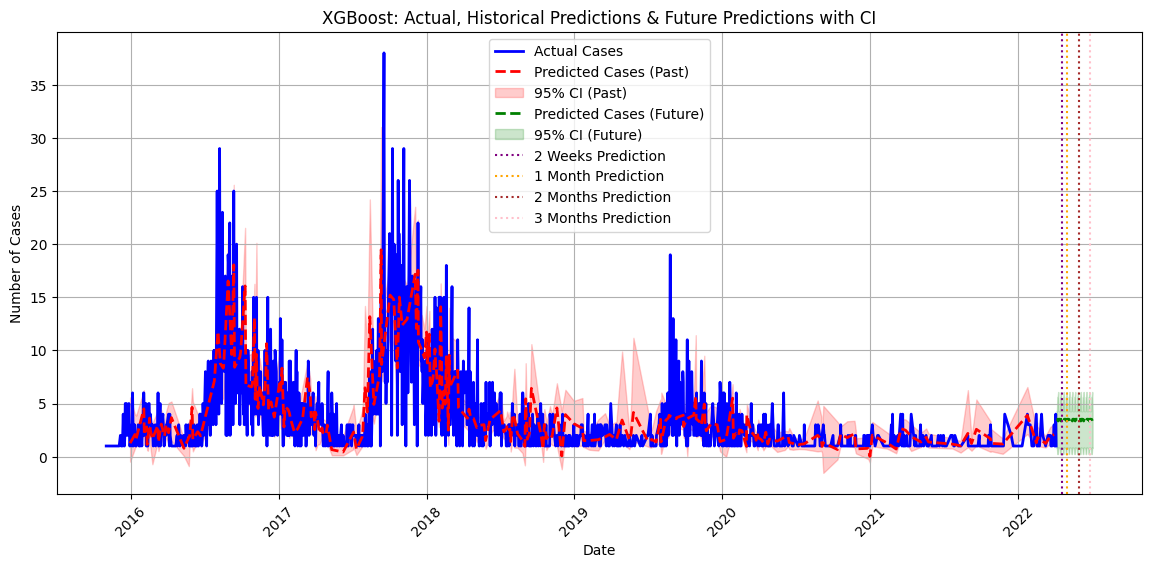

In [13]:
from datetime import timedelta

# 🔥 Generate future dates (90 days ahead)
last_date = kal_data['date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90, freq='D')

# 🔥 Convert to DataFrame
future_df = pd.DataFrame({"date": future_dates})

# 🔥 Extract time-based features (same as training)
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['day_of_week'] = future_df['date'].dt.dayofweek

# 🔥 Standardize features using pre-fitted scaler
X_future_scaled = scaler.transform(future_df.drop(columns=['date']))

# 🔥 Predict future cases
y_pred_future = xg_model.predict(X_future_scaled)

# 🔥 Bootstrapping for 95% CI on future predictions
n_bootstraps = 1000
y_pred_future_bootstrap = np.array([
    xg_model.fit(
        X_train_df.sample(frac=1, replace=True, random_state=i), 
        y_train_df.sample(frac=1, replace=True, random_state=i)
    ).predict(X_future_scaled) for i in range(n_bootstraps)
])

# 🔥 Compute 95% Confidence Intervals for Future Predictions
lower_bound_future = np.percentile(y_pred_future_bootstrap, 2.5, axis=0)
upper_bound_future = np.percentile(y_pred_future_bootstrap, 97.5, axis=0)

# 🔥 Add Predictions & CI to Future DataFrame
future_df['Predicted Cases (XGBoost)'] = y_pred_future
future_df['Lower Bound (95% CI)'] = lower_bound_future
future_df['Upper Bound (95% CI)'] = upper_bound_future

# 🔥 Bootstrapping for 95% CI on Historical Predictions (Test Data)
y_pred_historical_bootstrap = np.array([
    xg_model.fit(
        X_train_df.sample(frac=1, replace=True, random_state=i), 
        y_train_df.sample(frac=1, replace=True, random_state=i)
    ).predict(X_test_np) for i in range(n_bootstraps)
])

# 🔥 Compute 95% Confidence Intervals for Historical Predictions
lower_bound_historical = np.percentile(y_pred_historical_bootstrap, 2.5, axis=0)
upper_bound_historical = np.percentile(y_pred_historical_bootstrap, 97.5, axis=0)

# 🔥 Historical Predictions (Test Data)
df_results = pd.DataFrame({
    "Date": kal_data.loc[y_test.index, 'date'],
    "Actual Cases": y_test.values,
    "Predicted Cases (XGBoost)": y_pred_xg,
    "Lower Bound (95% CI)": lower_bound_historical,
    "Upper Bound (95% CI)": upper_bound_historical
}).sort_values(by="Date")

# 🔥 Extract specific future predictions
pred_2_weeks = future_df.loc[future_df['date'] == last_date + timedelta(weeks=2), 'Predicted Cases (XGBoost)'].values
pred_1_month = future_df.loc[future_df['date'] == last_date + timedelta(weeks=4), 'Predicted Cases (XGBoost)'].values
pred_2_months = future_df.loc[future_df['date'] == last_date + timedelta(weeks=8), 'Predicted Cases (XGBoost)'].values
pred_3_months = future_df.loc[future_df['date'] == last_date + timedelta(weeks=12), 'Predicted Cases (XGBoost)'].values

print(f"📅 Future Predictions with CI:")
print(f"➡️  2 Weeks: {pred_2_weeks[0] if len(pred_2_weeks) > 0 else 'N/A'}")
print(f"➡️  1 Month: {pred_1_month[0] if len(pred_1_month) > 0 else 'N/A'}")
print(f"➡️  2 Months: {pred_2_months[0] if len(pred_2_months) > 0 else 'N/A'}")
print(f"➡️  3 Months: {pred_3_months[0] if len(pred_3_months) > 0 else 'N/A'}")

# 🔥 Plot Historical & Future Predictions with Confidence Intervals
plt.figure(figsize=(14, 6))

# 📌 Plot historical actual cases
plt.plot(kal_data['date'], kal_data['case_count'], label="Actual Cases", color="blue", linewidth=2)

# 📌 Plot historical predicted cases
plt.plot(df_results["Date"], df_results["Predicted Cases (XGBoost)"], label="Predicted Cases (Past)", color="red", linestyle="--", linewidth=2)

# 📌 Add confidence intervals for historical predictions
plt.fill_between(df_results['Date'], df_results['Lower Bound (95% CI)'], df_results['Upper Bound (95% CI)'], color='red', alpha=0.2, label="95% CI (Past)")

# 📌 Plot future predictions
plt.plot(future_df['date'], future_df['Predicted Cases (XGBoost)'], label="Predicted Cases (Future)", color="green", linestyle="--", linewidth=2)

# 📌 Add confidence intervals for future predictions
plt.fill_between(future_df['date'], future_df['Lower Bound (95% CI)'], future_df['Upper Bound (95% CI)'], color='green', alpha=0.2, label="95% CI (Future)")

# 📌 Add markers for specific future predictions
plt.axvline(x=last_date + timedelta(weeks=2), color="purple", linestyle=":", label="2 Weeks Prediction")
plt.axvline(x=last_date + timedelta(weeks=4), color="orange", linestyle=":", label="1 Month Prediction")
plt.axvline(x=last_date + timedelta(weeks=8), color="brown", linestyle=":", label="2 Months Prediction")
plt.axvline(x=last_date + timedelta(weeks=12), color="pink", linestyle=":", label="3 Months Prediction")

# 📌 Formatting
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("XGBoost: Actual, Historical Predictions & Future Predictions with CI")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# 🔥 Show plot
plt.show()


##  LSTM deep learning 

Epoch 1/50


<positron-console-cell-14>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/berhe/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 16/50
67/67 ━━━━━━━━━━━━

<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-14>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


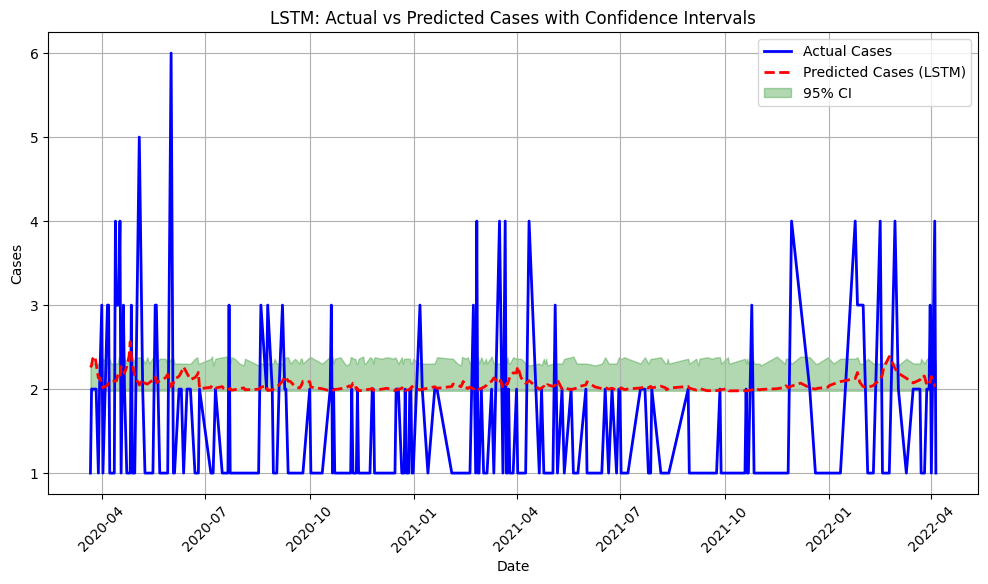

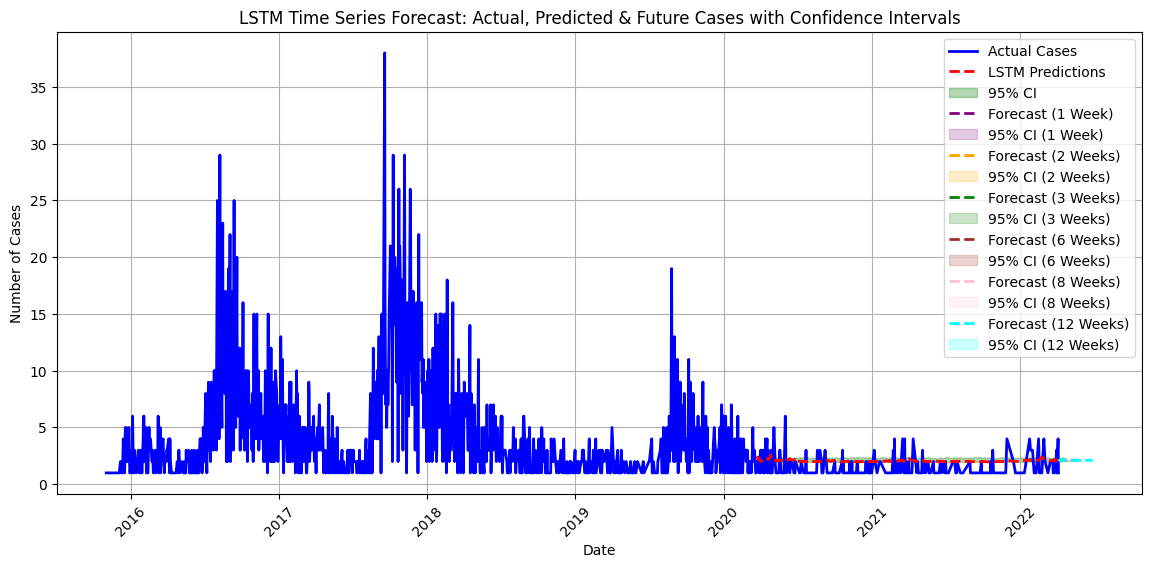

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load Kalazar data
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')

# Ensure 'date' column is in datetime format
kal_data['date'] = pd.to_datetime(kal_data['date'])

# Group Kalazar data by date and count cases
kal_data = kal_data.groupby('date').size().reset_index(name='case_count')

# Filter for relevant time period
kal_data = kal_data[kal_data["date"] >= "2015-11-01"]

# Fill missing values
kal_data['case_count'].fillna(0, inplace=True)

# Normalize case counts
scaler = MinMaxScaler()
scaled_cases = scaler.fit_transform(kal_data['case_count'].values.reshape(-1, 1))

# 🔥 Prepare Sequences
def create_sequences(data, seq_length=10):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X_seq, y_seq = create_sequences(scaled_cases, seq_length)

# Train-Test Split
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 🔥 Define LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 🔥 Train LSTM
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 🔥 Predict on Test Set
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 🔥 Compute Confidence Interval (Bootstrapping)
n_bootstraps = 1000
bootstrap_preds = []

for _ in range(n_bootstraps):
    sample_indices = np.random.choice(len(y_pred_lstm), len(y_pred_lstm), replace=True)
    sampled_preds = y_pred_lstm[sample_indices]
    bootstrap_preds.append(sampled_preds)

bootstrap_preds = np.array(bootstrap_preds)

# Compute 95% CI
lower_bound_lstm = np.percentile(bootstrap_preds, 2.5, axis=0).flatten()
upper_bound_lstm = np.percentile(bootstrap_preds, 97.5, axis=0).flatten()

# 🔥 Generate Future Predictions
future_steps = [7, 14, 21, 42, 56, 84]  # 1 week, 2 weeks, 3 weeks, 6 weeks, 8 weeks, 12 weeks
future_forecasts = {}
future_dates = {}
future_conf_int = {}

last_sequence = X_seq[-1].reshape(1, seq_length, 1)

for steps in future_steps:
    future_preds = []
    lower_ci = []
    upper_ci = []
    
    temp_sequence = last_sequence.copy()
    
    for _ in range(steps):
        next_pred = model.predict(temp_sequence)
        next_pred_inv = scaler.inverse_transform(next_pred)[0, 0]
        future_preds.append(next_pred_inv)
        
        # Bootstrapping for CI
        sample_preds = []
        for _ in range(n_bootstraps):
            sample_indices = np.random.choice(len(y_pred_lstm), len(y_pred_lstm), replace=True)
            sample_preds.append(y_pred_lstm[sample_indices].mean())
        
        lower_ci.append(np.percentile(sample_preds, 2.5))
        upper_ci.append(np.percentile(sample_preds, 97.5))
        
        # Update sequence
        next_pred_scaled = scaler.transform([[next_pred_inv]])
        temp_sequence = np.roll(temp_sequence, -1)
        temp_sequence[0, -1, 0] = next_pred_scaled
    
    future_forecasts[steps] = future_preds
    future_conf_int[steps] = (lower_ci, upper_ci)
    future_dates[steps] = pd.date_range(start=kal_data['date'].iloc[-1], periods=steps+1, freq='D')[1:]  # Exclude last observed date

# 🔥 Plot Actual vs Predicted with Confidence Intervals
plt.figure(figsize=(12, 6))
plt.plot(kal_data['date'].iloc[train_size+seq_length:], y_test_actual, label="Actual Cases", color="blue", linewidth=2)
plt.plot(kal_data['date'].iloc[train_size+seq_length:], y_pred_lstm, label="Predicted Cases (LSTM)", color="red", linestyle="--", linewidth=2)
plt.fill_between(kal_data['date'].iloc[train_size+seq_length:], lower_bound_lstm, upper_bound_lstm, color='green', alpha=0.3, label="95% CI")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("LSTM: Actual vs Predicted Cases with Confidence Intervals")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 🔥 Plot Future Forecasts with CI
plt.figure(figsize=(14, 6))

# 📌 Plot actual cases
plt.plot(kal_data['date'], kal_data['case_count'], label="Actual Cases", color="blue", linewidth=2)

# 📌 Plot LSTM predictions
plt.plot(kal_data['date'].iloc[train_size+seq_length:], y_pred_lstm, label="LSTM Predictions", color="red", linestyle="--", linewidth=2)

# 📌 Confidence Interval for Predictions
plt.fill_between(kal_data['date'].iloc[train_size+seq_length:], lower_bound_lstm, upper_bound_lstm, color='green', alpha=0.3, label="95% CI")

# 📌 Plot Future Predictions
colors = ["purple", "orange", "green", "brown", "pink", "cyan"]
labels = ["1 Week", "2 Weeks", "3 Weeks", "6 Weeks", "8 Weeks", "12 Weeks"]

for i, steps in enumerate(future_steps):
    plt.plot(future_dates[steps], future_forecasts[steps], linestyle="--", linewidth=2, color=colors[i], label=f"Forecast ({labels[i]})")
    
    # Confidence Interval
    plt.fill_between(future_dates[steps], future_conf_int[steps][0], future_conf_int[steps][1], 
                     color=colors[i], alpha=0.2, label=f"95% CI ({labels[i]})")

# 📌 Formatting
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("LSTM Time Series Forecast: Actual, Predicted & Future Cases with Confidence Intervals")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# 🔥 Show the plot
plt.show()


Epoch 1/50


<positron-console-cell-15>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/berhe/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125 
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 16/50
66/66 ━━━━━━━━━━━

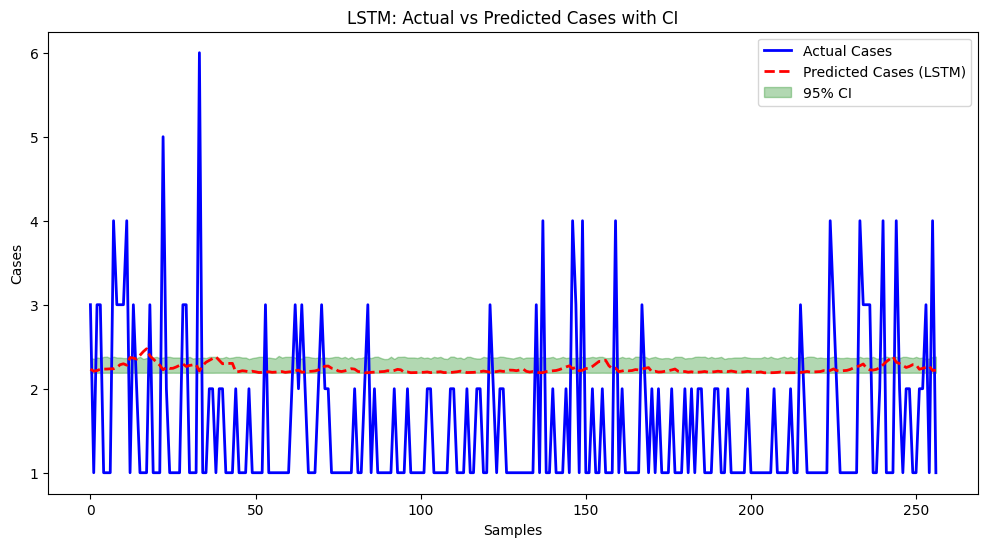

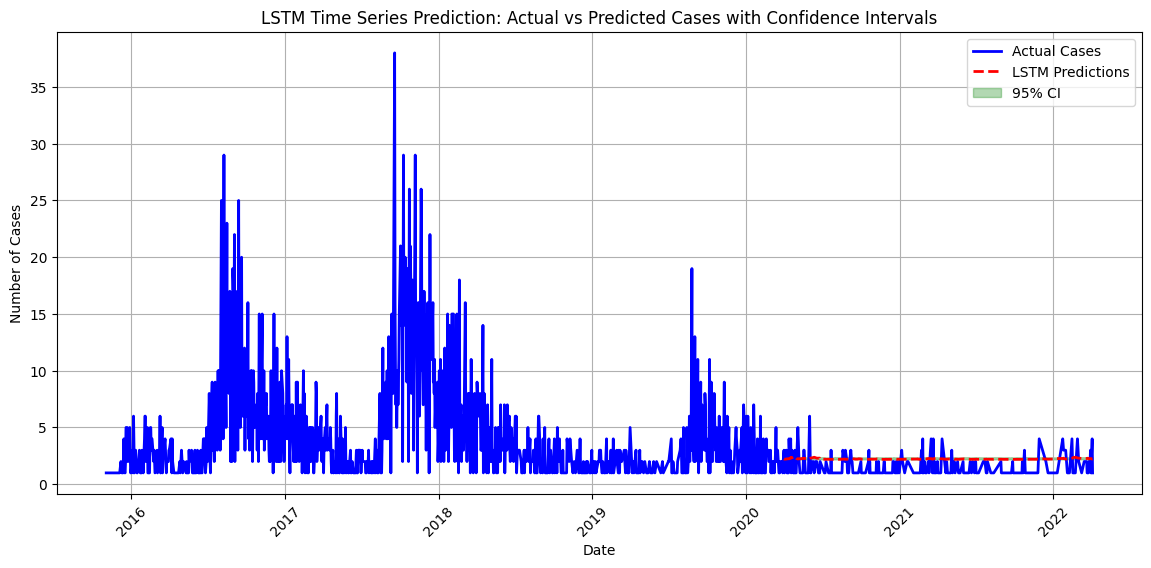

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load Kalazar data
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')

# Ensure 'date' column is in datetime format
kal_data['date'] = pd.to_datetime(kal_data['date'])

# Group Kalazar data by date and count cases
kal_data = kal_data.groupby('date').size().reset_index(name='case_count')

# Filter for dates greater than or equal to 2015-11-01
kal_data = kal_data[kal_data["date"] >= "2015-11-01"]

# Fill missing values in case count with 0
kal_data['case_count'].fillna(0, inplace=True)

# Define Features (X) and Target (y)
X = kal_data[['date']].copy()  # Using date as a feature (Need to extract time-based features)
y = kal_data['case_count']  # Target variable

# Convert 'date' to numerical features (Year, Month, Day, Day of Week)
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['day_of_week'] = X['date'].dt.dayofweek

# Drop the original 'date' column (since models can't process dates directly)
X.drop(columns=['date'], inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔥 Train-Test Split
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

# 🔥 Normalize Data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
scaled_test = scaler.transform(y_test.values.reshape(-1, 1))

# 🔥 Prepare Sequences
def create_sequences(data, seq_length=10):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X_train_seq, y_train_seq = create_sequences(scaled_train, seq_length)
X_test_seq, y_test_seq = create_sequences(scaled_test, seq_length)

# 🔥 Define LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 🔥 Train LSTM
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, verbose=1)

# 🔥 Predict & Inverse Transform
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# 🔥 Compute Confidence Interval (Bootstrapping)
n_bootstraps = 1000
bootstrap_preds = []

for _ in range(n_bootstraps):
    sample_indices = np.random.choice(len(y_pred_lstm), len(y_pred_lstm), replace=True)
    sampled_preds = y_pred_lstm[sample_indices]
    bootstrap_preds.append(sampled_preds)

bootstrap_preds = np.array(bootstrap_preds)

# Ensure lower and upper bounds are 1D using the bootstrap predictions
lower_bound_lstm = np.percentile(bootstrap_preds, 2.5, axis=0).flatten()
upper_bound_lstm = np.percentile(bootstrap_preds, 97.5, axis=0).flatten()

# Check dimensions
print(f"y_pred_lstm shape: {y_pred_lstm.shape}")
print(f"lower_bound_lstm shape: {lower_bound_lstm.shape}")
print(f"upper_bound_lstm shape: {upper_bound_lstm.shape}")

# Plot with corrected CI
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[seq_length:], label="Actual Cases", color="blue", linewidth=2)
plt.plot(y_pred_lstm, label="Predicted Cases (LSTM)", color="red", linestyle="--", linewidth=2)
plt.fill_between(range(len(y_pred_lstm)), lower_bound_lstm, upper_bound_lstm, color='green', alpha=0.3, label="95% CI")
plt.xlabel("Samples")
plt.ylabel("Cases")
plt.title("LSTM: Actual vs Predicted Cases with CI")
plt.legend()
plt.show()


# plot the actual cases and the prediction
plt.figure(figsize=(14, 6))

# 📌 Plot actual cases from the full dataset
plt.plot(kal_data['date'], kal_data['case_count'], label="Actual Cases", color="blue", linewidth=2)

# 📌 Plot LSTM predictions with corresponding test dates
plt.plot(kal_data['date'].iloc[train_size+seq_length:], y_pred_lstm, label="LSTM Predictions", color="red", linestyle="--", linewidth=2)

# 📌 Confidence Interval Shading
plt.fill_between(kal_data['date'].iloc[train_size+seq_length:], lower_bound_lstm, upper_bound_lstm, color='green', alpha=0.3, label="95% CI")

# 📌 Formatting
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("LSTM Time Series Prediction: Actual vs Predicted Cases with Confidence Intervals")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# 🔥 Show the plot
plt.show()



## Prophet

13:07:24 - cmdstanpy - INFO - Chain [1] start processing
13:07:25 - cmdstanpy - INFO - Chain [1] done processing


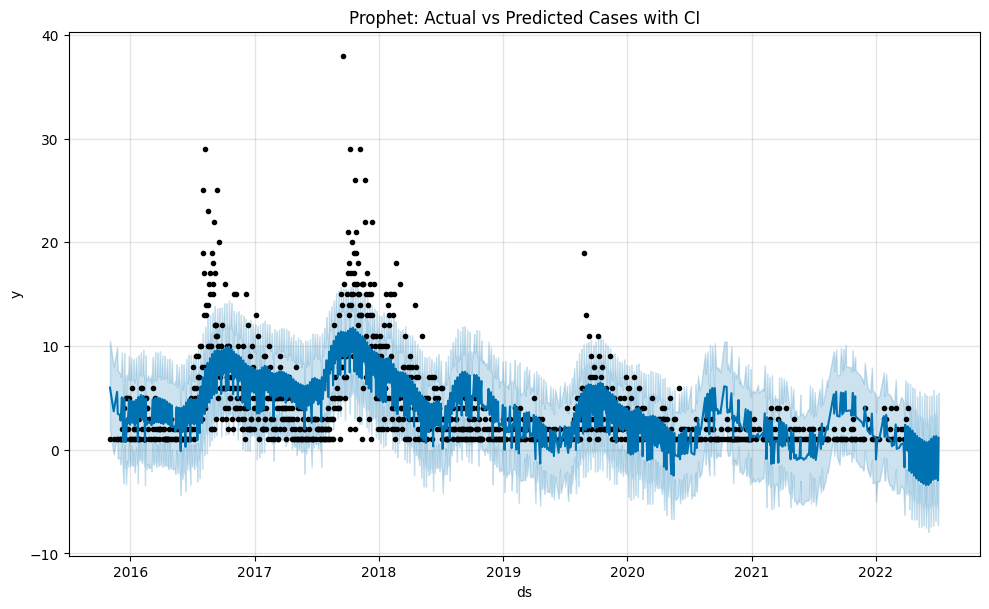

In [16]:
from prophet import Prophet

# 🔥 Prepare Data for Prophet
df_prophet = pd.DataFrame({"ds": kal_data["date"], "y": kal_data["case_count"]})

# 🔥 Train Prophet Model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# 🔥 Create Future DataFrame
future_prophet = prophet_model.make_future_dataframe(periods=90)

# 🔥 Predict
forecast_prophet = prophet_model.predict(future_prophet)

# 🔥 Visualization for Prophet
fig = prophet_model.plot(forecast_prophet)
plt.title("Prophet: Actual vs Predicted Cases with CI")
plt.show()
